written by Zwaneee

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix



In [2]:
train_dir = './train'
test_dir = './test'

### Data Exploration

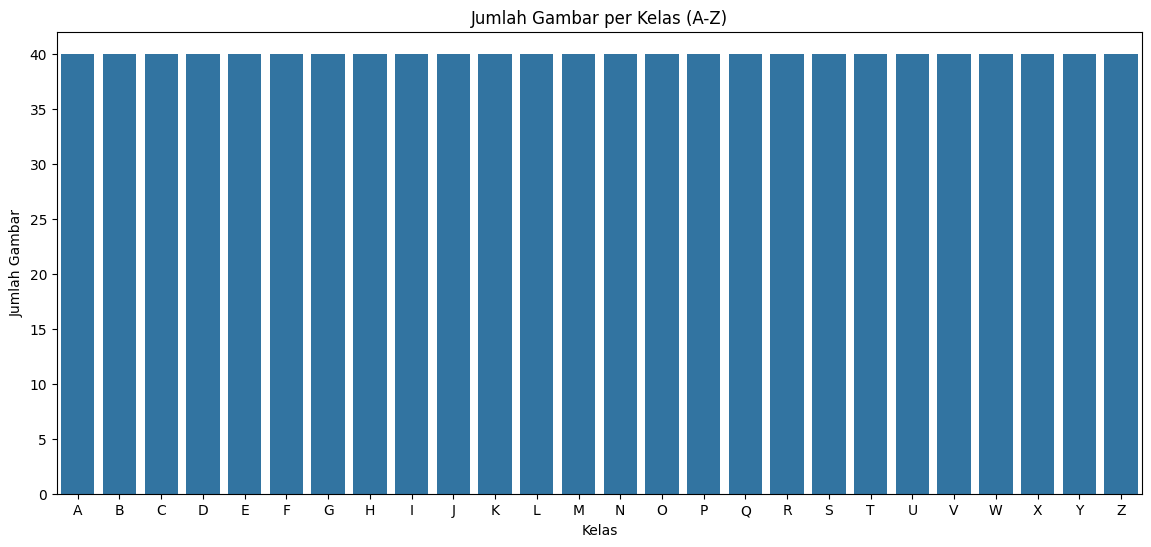

In [3]:
label_counts = {}
for label in sorted(os.listdir(train_dir)):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        label_counts[label] = len(os.listdir(label_path))

# Visualisasi jumlah gambar per kelas
plt.figure(figsize=(14,6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Jumlah Gambar per Kelas (A-Z)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

dari visualisasi diatas kita tahu bahwa data dari tiap folder berjumlah sama artinya sudah seimbang

In [4]:
image_shapes = []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = Image.open(img_path)
        image_shapes.append(img.size)
        break

print("Contoh dimensi gambar:", image_shapes)

Contoh dimensi gambar: [(862, 861), (3000, 3000), (2592, 1728), (2592, 1728), (2592, 1728), (2592, 1728), (2592, 1728), (2592, 1728), (2592, 1728), (838, 838), (796, 797), (2592, 1728), (1077, 1078), (2592, 1728), (2592, 1728), (3000, 3000), (2592, 1728), (1076, 1078), (3000, 3000), (1076, 1078), (2592, 1728), (2592, 1728), (3000, 3000), (3000, 3000), (3000, 3000), (2592, 1728)]


output diatas menunjukkan sample dari ukuran gambar tiap foldernya

In [5]:
def show_image_classes_from_directory(train_dir, n=4):
    class_labels = sorted(os.listdir(train_dir))
    num_classes = len(class_labels)
    
    fig, axarr = plt.subplots(nrows=num_classes, ncols=n, figsize=(n*2, num_classes*2))
    axarr = axarr.flatten()
    plt_id = 0

    for class_idx, class_label in enumerate(class_labels):
        class_path = os.path.join(train_dir, class_label)
        images = os.listdir(class_path)[:n]
        for i in range(n):
            image_path = os.path.join(class_path, images[i])
            image = Image.open(image_path).convert('L')  # convert to grayscale
            axarr[plt_id].imshow(image, cmap='gray')
            axarr[plt_id].set_xticks([])
            axarr[plt_id].set_yticks([])
            axarr[plt_id].set_title(f"Sign: {class_label}")
            plt_id += 1
    
    plt.tight_layout()
    plt.show()

fungsi diatas dibuat untuk menampilkan 4 sample gambar dari tiap folder train, dengan tujuan memahami gambar secara lebih baik

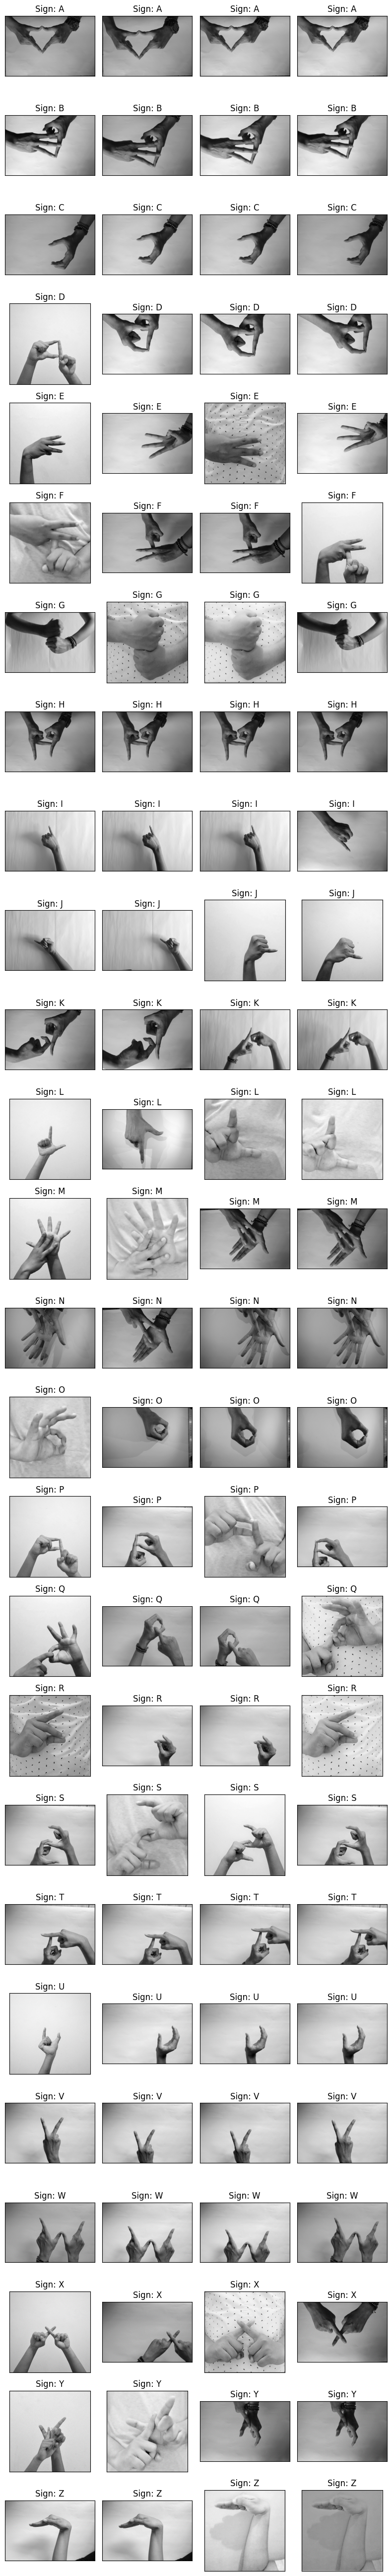

In [6]:
show_image_classes_from_directory(train_dir, n=4)

### Preprocessing Images

In [7]:
def load_and_preprocess_images(train_dir, target_size=(64, 64)):
    images = []
    labels = []

    for label in sorted(os.listdir(train_dir)):
        label_path = os.path.join(train_dir, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = Image.open(img_path).convert('L')  # Grayscale
                    img = img.resize(target_size)            # Resize ke 64x64
                    img = np.array(img) / 255.0              # Normalisasi 0–1 (MinMax)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Gagal load {img_path}: {e}")

    return np.array(images), np.array(labels)

- **Resize** : disini saya resize ke 64 agar lebih mudah untuk melatih model, sebelumnya saya sudah mencoba 96 dan 128 juga. untuk hasil prediksinya namun cenderung lebih baik di ukuran 64x64 tapi hasil f1 scorenya lebih baik di 128x128.

- **Grayscale** : Mengurangi dimensi warna gambar sehingga gambar menjadi berwarna hitam-putih. Cocok untuk dataset ini karena gambar dari handsign untuk bahasa isyarat tidak terlalu mementingkan warna melainkan bentuk yang lebih diutamakan.

- **Normalisasi** : Mengubah nilai pixel dari yang memiliki rentang 0 - 255 menjadi 0 - 1 (MinMax) atau mengubah data pixel menjadi berbentuk distribusi normal (Z-score). Dengan tujuan untuk meningkatkan performa model

In [8]:
X, y = load_and_preprocess_images(train_dir, target_size=(64, 64))
print(f"Dataset shape: {X.shape}, Label shape: {y.shape}")

Dataset shape: (1040, 64, 64), Label shape: (1040,)


melihat akumulasi gambar dari seluruh folder train

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # A jadi 0, B jadi 1, dst.
y_onehot = to_categorical(y_encoded, num_classes=26)    # One-hot encode

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Contoh label:", y[:50])
print("Encoded:", y_encoded[:50])
print("One-hot:", y_onehot[:50])

Label mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Contoh label: ['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B']
Encoded: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
One-hot: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


Penjelasan:
- `LabelEncoder()` mengubah label huruf ('A'–'Z') menjadi angka (0–25).

- `to_categorical()` mengubah angka tersebut menjadi one-hot encoding, yaitu bentuk vektor yang berisi 1 pada posisi labelnya, dan 0 di tempat lain.

Contoh:

`'A' ➜ 0 ➜ [1, 0, 0, ..., 0]`

`'B' ➜ 1 ➜ [0, 1, 0, ..., 0]`

Tujuan:
Model CNN menggunakan fungsi aktivasi softmax di output, sehingga label perlu dalam bentuk one-hot untuk menghitung akurasi dan loss dengan benar (menggunakan categorical_crossentropy).

In [10]:
X = X.reshape(-1, 64, 64, 1)

Penjelasan:
- Gambar grayscale awalnya berbentuk (64, 64).

- Model CNN memerlukan bentuk input (tinggi, lebar, channel).

- Karena grayscale, channel = 1.

- -1 menyesuaikan jumlah data secara otomatis.

Hasil Akhir:
- Data gambar siap dilatih dengan bentuk (jumlah_data, 64, 64, 1).

- Label sudah dalam format numerik dan one-hot untuk klasifikasi 26 huruf.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (832, 64, 64, 1) Val: (208, 64, 64, 1)


Bagian ini sudah terlihat antara data yang menjadi Train dan Value(test) dengan pembagian 80% dengan 20%

In [12]:
print("Distribusi label training:")
print(pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index())

print("Distribusi label val:")
print(pd.Series(np.argmax(y_val, axis=1)).value_counts().sort_index())

Distribusi label training:
0     32
1     32
2     32
3     32
4     32
5     32
6     32
7     32
8     32
9     32
10    32
11    32
12    32
13    32
14    32
15    32
16    32
17    32
18    32
19    32
20    32
21    32
22    32
23    32
24    32
25    32
Name: count, dtype: int64
Distribusi label val:
0     8
1     8
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    8
20    8
21    8
22    8
23    8
24    8
25    8
Name: count, dtype: int64


setelah kita melihat data terbagi secara benar, maka step selanjutnya adalah Data Augmentation

In [13]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
)

### Modelling

In [14]:
# Early Stopping & Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

##### **Early Stopping**

Penjelasan:
- Tujuannya adalah untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan pada `val_loss`.

- `monitor='val_loss'`: Memantau nilai loss pada data validasi.

- `patience=5`: Memberi toleransi 5 epoch tanpa peningkatan sebelum pelatihan dihentikan.

- `restore_best_weights=True`: Mengembalikan bobot model ke nilai terbaik selama pelatihan.

Ini membantu menghindari overfitting dan mempercepat proses pelatihan.

##### **ReduceLROnPlateau**

Penjelasan:
- Tujuan: Menurunkan learning rate secara otomatis saat pelatihan stagnan.

- `factor=0.5`: Mengurangi learning rate menjadi setengahnya jika tidak ada peningkatan.

- `patience=3`: Menunggu 3 epoch tanpa peningkatan sebelum menurunkan learning rate.

- `verbose=1`: Menampilkan informasi saat learning rate berubah.

Ini membantu model belajar lebih stabil saat sudah mendekati nilai minimum loss.

#### **Kesimpulan:**

Dengan menggabungkan EarlyStopping dan ReduceLROnPlateau, pelatihan menjadi:
- **Lebih efisien**

- **Mengurangi risiko overfitting**

- **Meningkatkan kemungkinan konvergensi optimal**

### Arsitektur Model 1 – CNN untuk Klasifikasi Huruf A-Z

Model ini dirancang untuk melakukan klasifikasi gambar huruf (A–Z) menggunakan pendekatan **Convolutional Neural Network (CNN)**. CNN sangat cocok untuk tugas **pengenalan citra**, karena mampu menangkap pola visual seperti tepi, sudut, dan bentuk secara bertahap.

##### Model Arsitektur CNN untuk Pengenalan Huruf

Model Convolutional Neural Network (CNN) ini dirancang untuk melakukan klasifikasi gambar huruf grayscale. Berikut adalah penjelasan detail mengenai arsitektur, cara kerja, dan konsep desainnya.

In [15]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')  # 26 kelas huruf
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### Penjelasan Per Layer

Arsitektur model terdiri dari beberapa layer yang masing-masing memiliki fungsi spesifik:

* **`Conv2D(32, (3,3), activation='relu')`**
    * Layer konvolusi pertama dengan 32 filter berukuran 3x3.
    * Fungsi aktivasi ReLU (Rectified Linear Unit) digunakan untuk menambahkan non-linearitas pada output dari layer konvolusi.
    * **Tujuan:** Menangkap fitur visual dasar dari gambar input, seperti tepi, garis, dan sudut.

* **`MaxPooling2D(2,2)`**
    * Layer pooling yang mengambil nilai maksimum dari setiap area 2x2 piksel pada feature map hasil konvolusi.
    * **Tujuan:** Mengurangi dimensi spasial data (downsampling), sehingga mengurangi jumlah parameter, mempercepat komputasi, dan membantu membuat representasi fitur menjadi lebih robust terhadap variasi posisi.

* **`Conv2D(64, (3,3), activation='relu')`**
    * Layer konvolusi kedua dengan 64 filter berukuran 3x3. Jumlah filter yang lebih banyak memungkinkan model untuk mempelajari fitur yang lebih kompleks dibandingkan layer pertama.
    * Fungsi aktivasi ReLU kembali digunakan.
    * **Tujuan:** Menangkap fitur tingkat menengah yang merupakan kombinasi dari fitur-fitur dasar yang telah dipelajari sebelumnya, seperti pola sederhana atau bagian dari bentuk.

* **`MaxPooling2D(2,2)`**
    * Layer pooling kedua, dengan fungsi yang sama seperti layer pooling sebelumnya.
    * **Tujuan:** Melakukan pengurangan dimensi lebih lanjut.

* **`Flatten()`**
    * Layer yang berfungsi untuk mengubah output dari layer sebelumnya (yang biasanya berupa matriks multi-dimensi/tensor) menjadi vektor satu dimensi (1D).
    * **Tujuan:** Menyiapkan data agar dapat diproses oleh layer Dense (fully connected).

* **`Dense(128, activation='relu')`**
    * Layer fully connected (terhubung penuh) dengan 128 neuron. Setiap neuron pada layer ini terhubung dengan semua output dari layer Flatten.
    * Fungsi aktivasi ReLU digunakan untuk memproses kombinasi fitur yang telah diekstraksi oleh layer-layer sebelumnya.
    * **Tujuan:** Melakukan pembelajaran tingkat tinggi berdasarkan fitur-fitur yang telah diratakan dan mengidentifikasi pola-pola kompleks.

* **`Dense(26, activation='softmax')`**
    * Layer output fully connected dengan 26 neuron, di mana masing-masing neuron mewakili satu kelas (dalam kasus ini, huruf A-Z).
    * Fungsi aktivasi softmax digunakan untuk mengubah output dari layer ini menjadi distribusi probabilitas. Setiap neuron akan menghasilkan nilai probabilitas antara 0 dan 1, dan total dari semua probabilitas neuron adalah 1.
    * **Tujuan:** Memberikan prediksi akhir berupa probabilitas untuk setiap kelas huruf, di mana kelas dengan probabilitas tertinggi dianggap sebagai prediksi model.

##### Cara Kerja

1.  **Input:** Model menerima gambar grayscale dengan ukuran 64x64 piksel (dimensi input: 64x64x1).
2.  **Ekstraksi Fitur:** Gambar dilewatkan melalui serangkaian layer konvolusi (`Conv2D`) dan pooling (`MaxPooling2D`). Layer konvolusi bertugas mengekstrak fitur-fitur visual dari gambar, mulai dari yang sederhana hingga yang lebih kompleks. Layer pooling mengurangi dimensi data sambil mempertahankan informasi penting.
3.  **Flattening:** Setelah fitur-fitur penting diekstraksi dan dimensinya dikurangi, output dari layer konvolusi/pooling terakhir diubah menjadi vektor satu dimensi oleh layer `Flatten`.
4.  **Klasifikasi:** Vektor fitur ini kemudian diproses oleh satu atau lebih layer `Dense`. Layer Dense pertama (dengan 128 neuron dan aktivasi ReLU) memproses fitur-fitur ini lebih lanjut. Layer Dense terakhir (dengan 26 neuron dan aktivasi softmax) melakukan klasifikasi akhir.
5.  **Output:** Output akhir dari model adalah vektor probabilitas 26 dimensi. Setiap elemen dalam vektor ini merepresentasikan probabilitas bahwa gambar input termasuk dalam salah satu dari 26 kelas huruf. Huruf dengan probabilitas tertinggi dianggap sebagai prediksi model.

##### Konsep Desain

* **Sederhana tapi Efektif:** Arsitektur yang digunakan relatif ringan dan tidak terlalu dalam, namun cukup efektif untuk dataset pengenalan huruf yang tidak terlalu kompleks.
* **Hierarki Fitur:** Desain CNN secara inheren memungkinkan pembelajaran fitur secara hierarkis. Layer awal mempelajari fitur dasar (seperti tepi), dan layer yang lebih dalam mempelajari fitur yang lebih kompleks (seperti bentuk atau pola) yang dibangun dari fitur-fitur pada layer sebelumnya.
* **Softmax untuk Klasifikasi Multi-Kelas:** Penggunaan fungsi aktivasi softmax pada layer output sangat cocok untuk tugas klasifikasi multi-kelas, di mana setiap input harus dipetakan ke salah satu dari beberapa kelas eksklusif (dalam hal ini, 26 huruf).

##### Kesimpulan

Model CNN ini dibangun dengan arsitektur yang relatif sederhana namun dirancang untuk mampu mengenali huruf dengan akurasi yang tinggi. Kemampuannya berasal dari penggunaan layer konvolusi untuk ekstraksi fitur visual secara efektif dari gambar grayscale berukuran kecil, diikuti oleh layer fully connected untuk melakukan klasifikasi berdasarkan fitur-fitur tersebut.

### Arsitektur Model 2 – CNN yang Lebih Kompleks

Model 2 merupakan pengembangan dari Model 1 yang ditingkatkan dengan teknik **regularisasi dan normalisasi** untuk meningkatkan akurasi serta mengurangi risiko overfitting. Model ini masih bertujuan untuk mengklasifikasikan gambar huruf A–Z, tetapi dengan kedalaman dan kompleksitas yang lebih tinggi.

In [16]:
# model2 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(0.25),

#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(0.25),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(26, activation='softmax')
# ])

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

##### Penjelasan Per Layer

Berikut adalah rincian dari setiap komponen dalam arsitektur Model 2:

* **`Conv2D` + `BatchNormalization` (32 filter)**
    * Layer konvolusi pertama dengan 32 filter untuk ekstraksi fitur awal. Menggunakan `padding='same'` untuk memastikan ukuran output spasial sama dengan ukuran input.
    * `BatchNormalization` diterapkan setelah konvolusi untuk menormalisasi output dari layer, yang membantu menstabilkan dan mempercepat proses pelatihan.

* **`MaxPooling2D` & `Dropout(0.25)`**
    * `MaxPooling2D` digunakan untuk mengurangi dimensi spasial (downsampling) dari feature maps.
    * `Dropout` dengan rate 0.25 diterapkan setelah pooling. Selama pelatihan, ini secara acak menonaktifkan 25% neuron, yang membantu mencegah overfitting dengan mengurangi ketergantungan antar neuron.

* **`Conv2D` + `BatchNormalization` (64 filter)**
    * Layer konvolusi kedua dengan 64 filter, memungkinkan model untuk menangkap fitur yang lebih kompleks dari output layer sebelumnya.
    * `BatchNormalization` kembali digunakan untuk menjaga stabilitas.

* **`Conv2D` + `BatchNormalization` (128 filter)**
    * Layer konvolusi ketiga yang lebih dalam dengan 128 filter. Tujuannya adalah untuk menangkap pola dan detail yang lebih halus pada citra.
    * `BatchNormalization` diterapkan juga di sini.
    * *(Catatan: Berdasarkan deskripsi "6 (lebih dalam)" pada tabel perbedaan, kemungkinan ada lebih banyak layer Conv2D+BN sebelum flatten, namun teks hanya merinci hingga 128 filter. Saya akan mengikuti teks yang diberikan untuk detail layer.)*

* **`Flatten` + `Dense(256)`**
    * `Flatten`: Mengubah matriks fitur 2D (atau 3D jika termasuk channel) dari layer konvolusi/pooling terakhir menjadi vektor 1D.
    * `Dense(256)`: Layer fully connected dengan 256 neuron dan aktivasi (kemungkinan ReLU, meskipun tidak secara eksplisit disebutkan di sini, ini adalah praktik umum). Layer ini memproses fitur yang telah diratakan.

* **`Dropout(0.5)`**
    * Layer `Dropout` dengan rate yang lebih tinggi (0.5) diterapkan sebelum layer output. Ini berarti 50% neuron akan dinonaktifkan secara acak selama pelatihan, memberikan regularisasi yang lebih kuat untuk mencegah overfitting pada tahap akhir pemrosesan fitur.

* **`Dense(26, activation='softmax')`**
    * Layer output fully connected dengan 26 neuron.
    * Fungsi aktivasi `softmax` digunakan untuk menghasilkan distribusi probabilitas atas 26 kelas huruf (A-Z), di mana nilai tertinggi menunjukkan prediksi huruf oleh model.

##### Perbedaan dengan Model 1

Berikut adalah perbandingan antara Model 1 dan Model 2:

| Fitur                | Model 1       | Model 2                               |
| :------------------- | :------------ | :------------------------------------ |
| Jumlah Conv Layer    | 2             | 3+ (lebih dalam, berdasarkan 128 filter dan keterangan "6" pada teks asli) |
| Normalisasi          | ❌ Tidak ada  | ✅ `BatchNormalization` digunakan     |
| Dropout              | ❌ Tidak ada  | ✅ Ada untuk mengurangi overfitting   |
| Kompleksitas         | Sederhana     | Tinggi (lebih banyak parameter)       |
| Regularisasi         | Tidak ada     | Ada (`Dropout` + `BatchNormalization`)|

*(Catatan: Teks asli menyebutkan "Jumlah Conv Layer ... 6 (lebih dalam)" untuk Model 2 pada tabel, namun deskripsi layer hanya merinci 3 blok Conv2D+BN. Tabel di atas mencoba merekonsiliasi ini, namun jika ada 6 layer konvolusi, deskripsi per layer di atas kurang lengkap berdasarkan teks sumber.)*

##### Keuntungan Model 2

Model 2 menawarkan beberapa keunggulan dibandingkan arsitektur Model 1:

* **Lebih Dalam:** Dengan lebih banyak layer konvolusi, model memiliki kapasitas untuk mempelajari dan menangkap hierarki fitur yang lebih kaya dan kompleks dari data input.
* **Lebih Stabil dalam Pelatihan:** Penggunaan `BatchNormalization` di setiap layer konvolusi membantu menstabilkan distribusi input ke layer berikutnya, yang dapat mempercepat konvergensi dan memungkinkan penggunaan learning rate yang lebih tinggi.
* **Lebih Tahan Overfitting:** Implementasi `Dropout` pada beberapa titik dalam arsitektur (setelah pooling dan sebelum layer output) berfungsi sebagai teknik regularisasi yang efektif, membantu model untuk generalisasi lebih baik pada data yang tidak terlihat.

##### Kesimpulan

Model 2 dirancang sebagai versi yang lebih canggih dan kompleks dibandingkan Model 1. Dengan mengintegrasikan arsitektur yang lebih dalam, `BatchNormalization` untuk stabilitas dan percepatan pelatihan, serta `Dropout` untuk regularisasi, model ini bertujuan untuk mencapai akurasi yang lebih tinggi dan kemampuan generalisasi yang lebih baik dalam tugas klasifikasi huruf A-Z pada gambar. Kombinasi teknik ini diharapkan dapat mengatasi tantangan seperti overfitting dan variasi dalam data input secara lebih efektif.

In [17]:
# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Train model
history1 = model1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.0645 - loss: 3.3274 - val_accuracy: 0.2548 - val_loss: 3.1404 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2451 - loss: 2.9571 - val_accuracy: 0.3990 - val_loss: 2.1628 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4789 - loss: 1.9244 - val_accuracy: 0.4808 - val_loss: 1.8039 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5498 - loss: 1.4339 - val_accuracy: 0.5433 - val_loss: 1.5409 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6482 - loss: 1.2378 - val_accuracy: 0.7019 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7540 - loss: 0.9235 - val_accuracy: 0.7163 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7661 - loss: 0.8187 - val_accuracy: 0.75

Pada kode ini, model1 dikompilasi menggunakan optimizer Adam dengan learning rate 0.001, loss function `categorical_crossentropy` untuk klasifikasi multi-kelas, dan metrik accuracy untuk mengukur performa. Proses training dilakukan selama maksimal 50 epoch menggunakan data yang telah diaugmentasi melalui `datagen.flow()`, yang membantu meningkatkan keragaman data agar model tidak overfitting. Validasi dilakukan dengan `X_val` dan `y_val` untuk memantau kinerja model di data yang tidak dilatih. Dua callback digunakan: EarlyStopping untuk menghentikan pelatihan lebih awal jika validasi tidak membaik, dan ReduceLROnPlateau untuk menurunkan learning rate secara otomatis jika model mulai stagnan.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


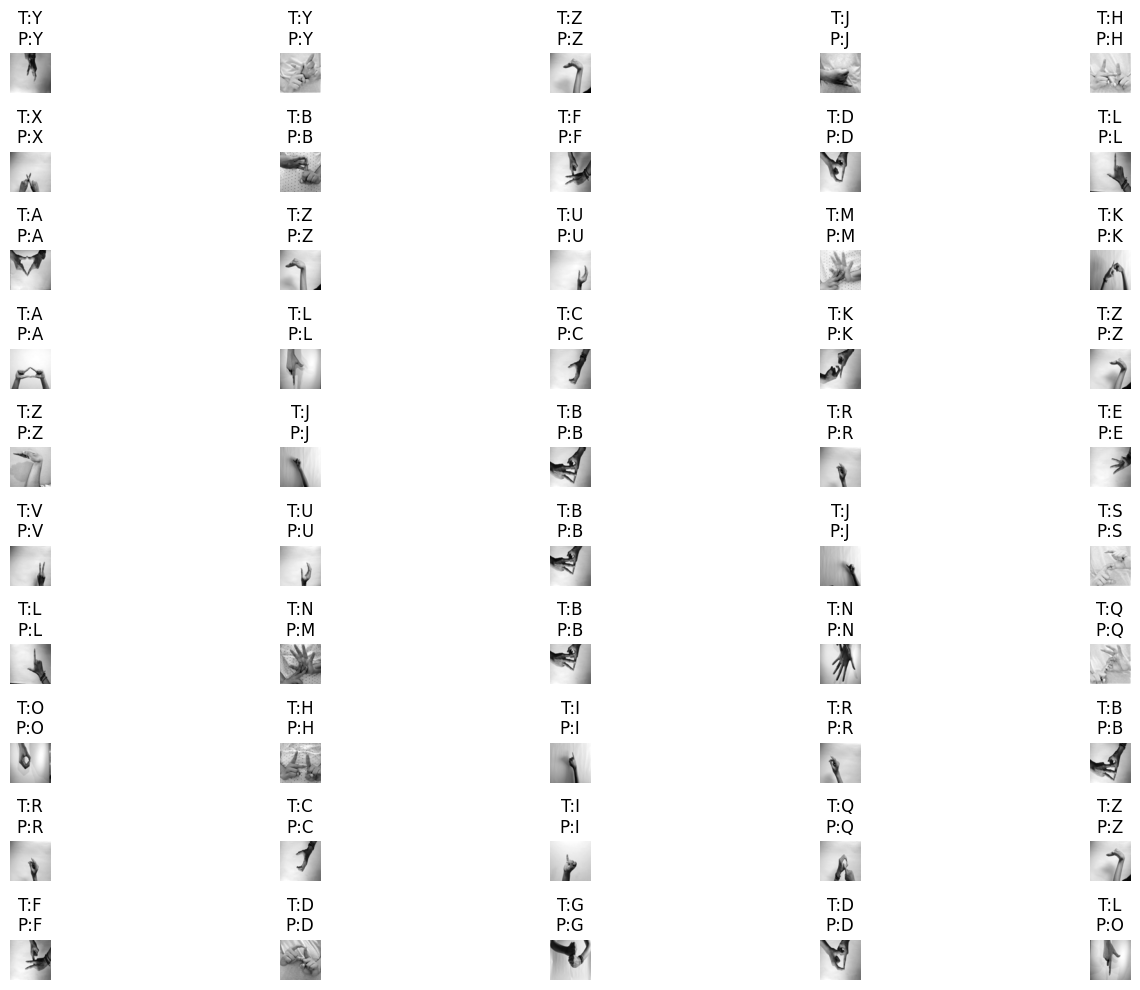

In [18]:
num_samples = 50
X_check = X_val[:num_samples]
y_true = np.argmax(y_val[:num_samples], axis=1)

y_pred = np.argmax(model1.predict(X_check), axis=1)

true_labels = label_encoder.inverse_transform(y_true)
pred_labels = label_encoder.inverse_transform(y_pred)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(10, 5, i+1)
    plt.imshow(X_check[i].reshape(64, 64), cmap='gray')
    plt.title(f"T:{true_labels[i]}\nP:{pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

plot diatas adalah untuk menunjukkan hasil prediksi dari model dan foto aktual

In [19]:
model2.compile(optimizer=Adam(learning_rate=0.0005),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history2 = model2.fit(
    datagen.flow(X_train, y_train, batch_size=32, shuffle=True),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0430 - loss: 3.2881 - val_accuracy: 0.1731 - val_loss: 3.2046 - learning_rate: 5.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1319 - loss: 3.1519 - val_accuracy: 0.2500 - val_loss: 2.8572 - learning_rate: 5.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2506 - loss: 2.7011 - val_accuracy: 0.4279 - val_loss: 2.2170 - learning_rate: 5.0000e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5021 - loss: 2.0387 - val_accuracy: 0.5337 - val_loss: 1.8458 - learning_rate: 5.0000e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5226 - loss: 1.7215 - val_accuracy: 0.5577 - val_loss: 1.6081 - learning_rate: 5.0000e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5519 - loss: 1.5306 - val_accuracy: 0.5433 - val_loss: 1.5268 - learning_rate: 5.0000e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6354 - loss: 1.2

bagian ini sama saja, yang beda hanya learning ratenya saya turunkan

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


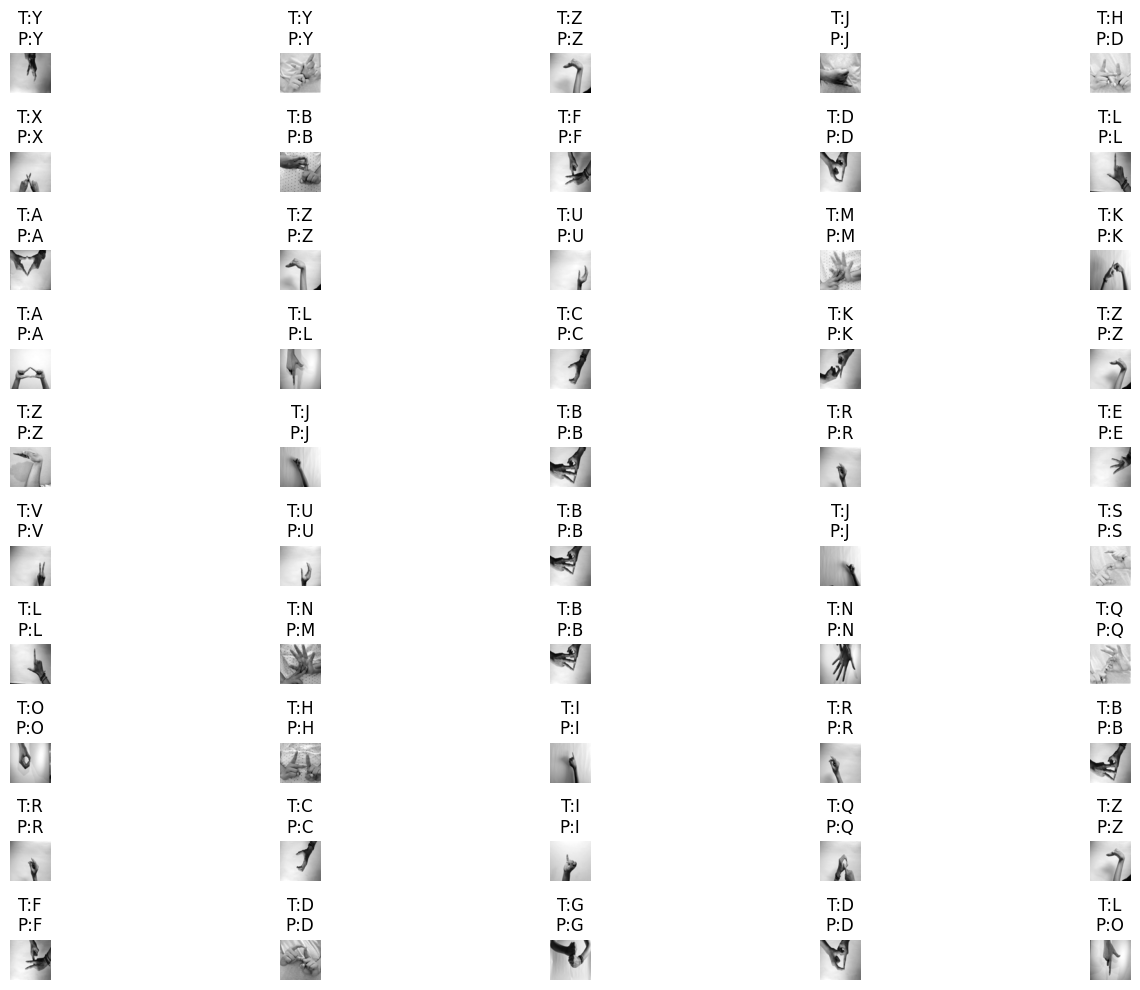

In [20]:
num_samples = 50
X_check = X_val[:num_samples]
y_true = np.argmax(y_val[:num_samples], axis=1)

y_pred = np.argmax(model2.predict(X_check), axis=1)

true_labels = label_encoder.inverse_transform(y_true)
pred_labels = label_encoder.inverse_transform(y_pred)

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(10, 5, i+1)
    plt.imshow(X_check[i].reshape(64, 64), cmap='gray')
    plt.title(f"T:{true_labels[i]}\nP:{pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

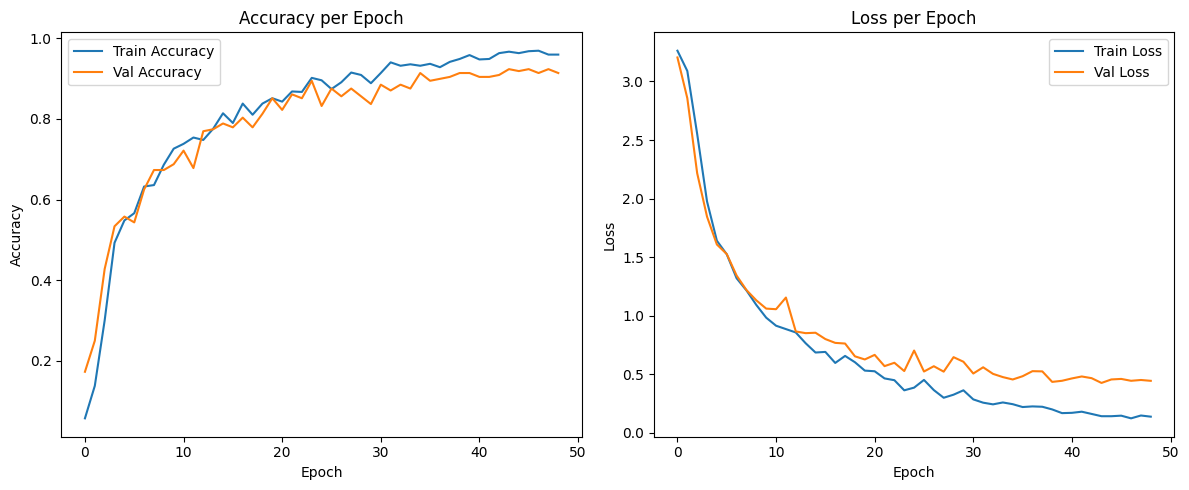

In [21]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


dari hasil visualisasi diatas dapat disimpulkan bahwa semakin meningkatnya epoch, maka akurasi juga meningkat serta loss semakin turun. dikarenakan model akan mempelajari pola secara terus-menerus.

In [22]:
# y_true = label sebenarnya
# y_pred = prediksi dari model

f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

print(classification_report(y_true, y_pred))


F1 Score: 0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       1.00      0.75      0.86         4
          12       0.50      1.00      0.67         1
          13       1.00      0.50      0.67         2
          14       0.50      1.00      0.67         1
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         3
          18

##### **Kesimpulan Evaluasi Model**

Model klasifikasi huruf ini menunjukkan kinerja yang sangat baik pada data uji. Metrik evaluasi utama yang diperoleh adalah sebagai berikut:

* **F1 Score Rata-rata Tertimbang (Weighted):** 0.94
    * Nilai ini mengindikasikan keseimbangan yang baik antara *precision* (ketepatan prediksi) dan *recall* (kemampuan menemukan semua instance yang benar) di seluruh kelas huruf.

* **Akurasi Keseluruhan:** 94%
    * Dari 50 data uji, 47 di antaranya berhasil diklasifikasikan dengan benar.

* **Precision dan Recall:**
    * Sebagian besar kelas memiliki nilai *precision* dan *recall* yang mendekati atau sama dengan 1.00. Hal ini menunjukkan bahwa model sangat jarang melakukan kesalahan dalam memprediksi dan mampu mengidentifikasi hampir semua instance dari kelas tersebut.

* **Kelas dengan *Support* Rendah:**
    * Beberapa kelas, seperti label 4, 8, 14, dan 24, memiliki jumlah data uji yang sedikit (*support* rendah). Akibatnya, nilai F1-score untuk kelas-kelas ini sedikit lebih rendah, yaitu sekitar 0.67. Hal ini wajar terjadi karena model memiliki lebih sedikit contoh untuk dipelajari pola karakteristik dari kelas-kelas tersebut.

* **Macro Average:** ≈0.93
    * Rata-rata F1-score antar kelas ini tetap tinggi, menunjukkan bahwa performa model relatif merata di seluruh kelas meskipun terdapat perbedaan dalam jumlah sampel data uji.

##### **Kesimpulan Secara General**

Secara keseluruhan, model ini berhasil mengenali huruf-huruf dengan tingkat akurasi dan konsistensi yang sangat baik. Nilai F1-score yang tinggi dan distribusi performa yang merata di sebagian besar kelas mengindikasikan bahwa arsitektur Convolutional Neural Network (CNN) dan teknik pelatihan yang digunakan sudah efektif.

Meskipun demikian, terdapat potensi untuk melakukan peningkatan performa pada kelas-kelas dengan jumlah sampel data yang rendah. Penambahan data untuk kelas-kelas tersebut atau penggunaan teknik *data augmentation* mungkin dapat membantu model dalam mempelajari pola dengan lebih baik dan meningkatkan kinerja secara keseluruhan.


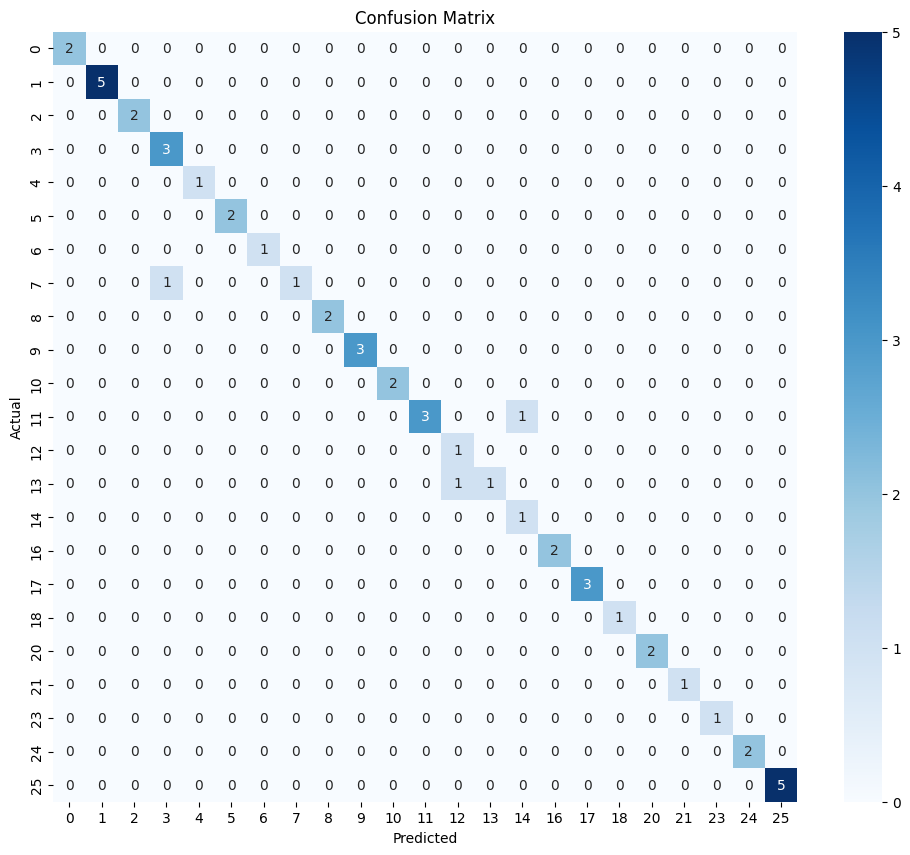

In [23]:
# y_true → label sebenarnya
# y_pred → prediksi model Anda

cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


dari confusion matrix diatas terlihat bahwa model sudah cukup baik dalam memprediksi hasilnya, dengan jumlah paling banyak salah prediksi adalah 5.

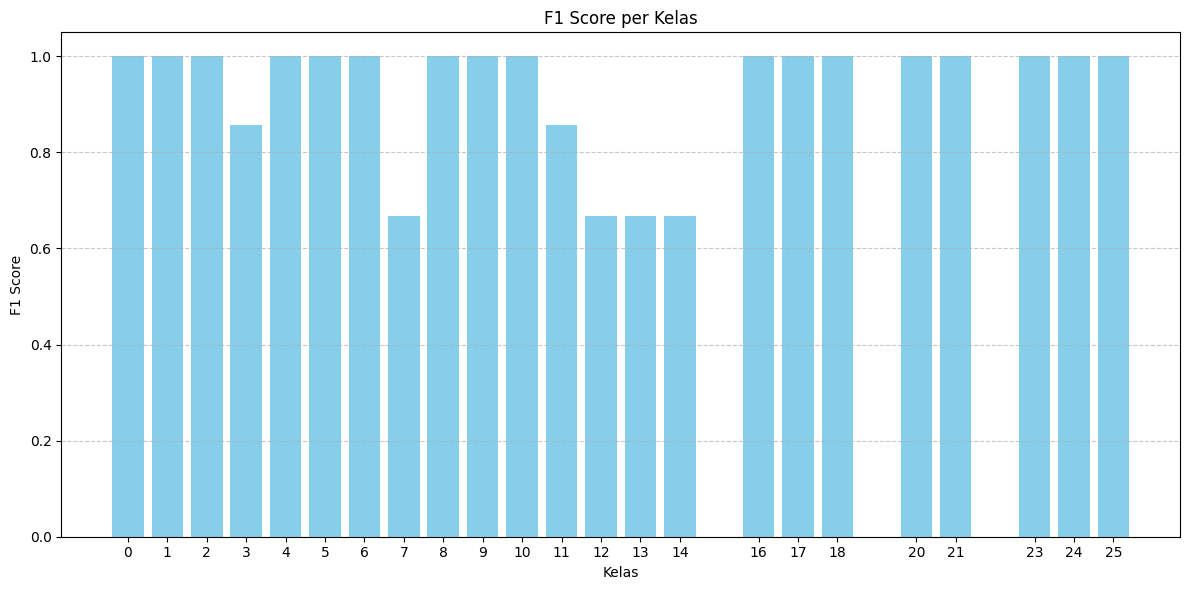

In [24]:
report = classification_report(y_true, y_pred, output_dict=True)

f1_scores = {k: v['f1-score'] for k, v in report.items() if k.isdigit()}

f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Kelas', 'F1 Score'])
f1_df['Kelas'] = f1_df['Kelas'].astype(int)
f1_df = f1_df.sort_values('Kelas')

plt.figure(figsize=(12, 6))
plt.bar(f1_df['Kelas'], f1_df['F1 Score'], color='skyblue')
plt.xlabel('Kelas')
plt.ylabel('F1 Score')
plt.title('F1 Score per Kelas')
plt.ylim(0, 1.05)
plt.xticks(f1_df['Kelas'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Plot diatas menunjukkan performa model klasifikasi untuk setiap kelas (kemungkinan huruf). Batang tinggi menandakan F1 Score yang baik (keseimbangan antara ketepatan dan kemampuan menemukan semua huruf yang benar untuk kelas tersebut). Sebagian besar kelas memiliki F1 Score tinggi, namun beberapa kelas (terlihat batangnya lebih pendek) menunjukkan performa yang lebih rendah. Kelas 15, 19, dan 22 tidak muncul, kemungkinan karena tidak ada prediksi atau tidak ada data sebenarnya untuk kelas tersebut dalam pengujian.

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_test_filenames = sorted(os.listdir(test_dir))

X_test = []
for fname in X_test_filenames:
    img_path = os.path.join(test_dir, fname)
    img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)

X_test = np.array(X_test)

y_pred_proba = model2.predict(X_test) # JANGAN LUPA DIGANTI KALO MAU SUBMIT PAKE MODEL LAIN
y_pred = np.argmax(y_pred_proba, axis=1)

label_mapping = {i: chr(65+i) for i in range(26)}
y_pred_labels = [label_mapping[i] for i in y_pred]

# Buat DataFrame submission
submission_df = pd.DataFrame({
    'filename': X_test_filenames,
    'label': y_pred_labels
})

submission_df.to_csv('submission12.csv', index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
